# Drug toxicity screening on human iPSC-derived cardiomyocites

## Background

iPSCs are valuable resource to model drug interactions with different tissue and are frequenly used in drug screens to gain insights into drug specificity and toxicity. Tyrosine kinase inhibitors (TKIs) are frequently used drugs in cancer treatment. Unfortunately, cardiomyopathy may occur as a severe side effect of these drugs due to cardiotoxicity.   
  
Here, you will compare the transcriptomes of iPSC-derived cardiomyocites treated with two different FDA-approved TKIs to investigate their toxicity and gain insights into the biological pathways potentially leading to cardiotoxicity.
- Bortezomib
- Gefinitib

## Objectives
1. Explore the impact on global gene expression patterns (PCA).
2. Identify differentially expressed genes (DEGs) between mutant and WT for both drugs.
3. Visualized DEGs with volcano plots and heatmaps.
4. Perform GO enrichment to determine affected biological pathways.
5. Interpret the cardiotoxic potential of these drugs, and what cellular mechansims they might disrupt.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import scanpy as sc
import anndata as ad
import os
import pandas as pd
import gseapy
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [2]:
counts = pd.read_csv(
    "Session_3_4/split_datasets/counts_msn05_group_6.txt", sep="\t", index_col=0
)
counts

,BOR_1,BOR_2,BOR_3,BOR_4,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,CTRL_9,CTRL_10,CTRL_11,CTRL_12,GEF_1,GEF_2,GEF_3,GEF_4
DDX11L1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WASH7P,44,28,38,78,147,63,65,201,43,54,54,43,66,25,123,97,58,85,61,36
MIR6859-1,7,4,3,4,24,9,0,5,11,6,6,4,5,2,13,12,2,10,6,4
MIR1302-2HG,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
MIR1302-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND6,13765,15012,13291,48494,107036,73372,45472,8313,28995,54639,40297,32030,132198,62151,81016,73551,32612,29949,136864,52715
TRNE,0,0,0,0,1,0,0,0,0,1,0,1,0,0,5,0,0,0,1,1
CYTB,35036,39284,28975,126948,337937,242836,146674,17113,110922,143736,120934,89561,359665,148701,251132,238506,115165,117685,306581,126033
TRNT,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [3]:
metadata_df = pd.read_csv(
    "Session_3_4/split_datasets/metadata_msn05_group_6.txt", sep="\t", index_col=0
)
metadata_df

,treatment,Concentration,cell_line,cell_type,replicate
BOR_1,Bortezomib,0.3uM,MSN05,cardiomyocytes,1
BOR_2,Bortezomib,0.3uM,MSN05,cardiomyocytes,2
BOR_3,Bortezomib,0.3uM,MSN05,cardiomyocytes,3
BOR_4,Bortezomib,0.3uM,MSN05,cardiomyocytes,4
CTRL_1,Control,0nM,MSN05,cardiomyocytes,1
CTRL_2,Control,0nM,MSN05,cardiomyocytes,2
CTRL_3,Control,0nM,MSN05,cardiomyocytes,3
CTRL_4,Control,0nM,MSN05,cardiomyocytes,4
CTRL_5,Control,0nM,MSN05,cardiomyocytes,5
CTRL_6,Control,0nM,MSN05,cardiomyocytes,6


# PCA

In [4]:
total_reads = counts.sum(axis=0)
normalized_count_table = (counts / total_reads) * 1000000
log_transformed_counts = np.log2(normalized_count_table + 1)

In [5]:
scaler = StandardScaler()

scaled_table = scaler.fit_transform(log_transformed_counts.T)

In [6]:
pca = PCA()

pca_result_matrix = pca.fit_transform(scaled_table)

In [7]:
np.shape(pca_result_matrix)

(20, 20)

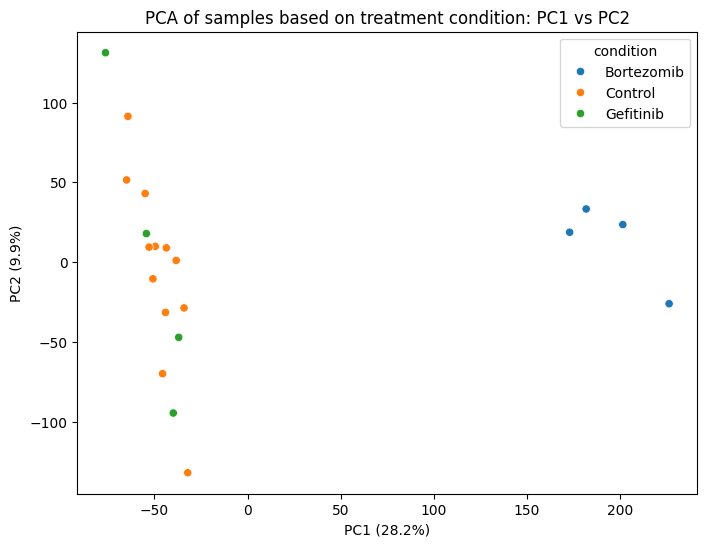

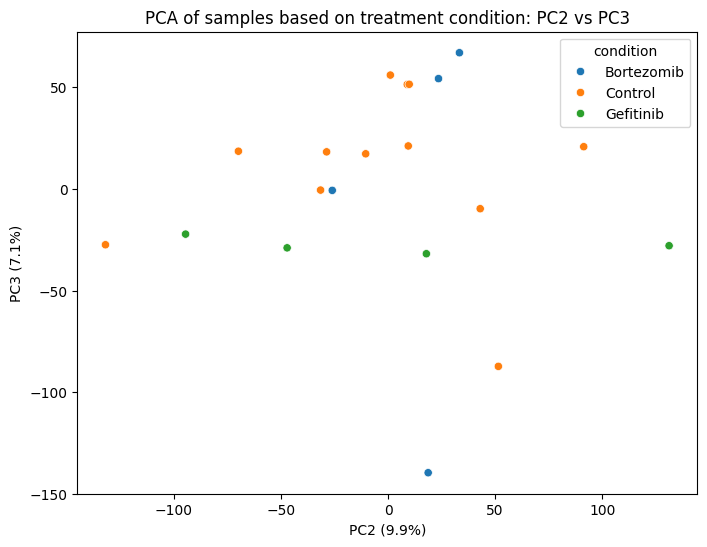

In [8]:
plot_df = pd.DataFrame(
    {
        "PC1": pca_result_matrix[:, 0],
        "PC2": pca_result_matrix[:, 1],
        "PC3": pca_result_matrix[:, 2],
        "condition": metadata_df["treatment"].values,
    }
)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="condition")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.title("PCA of samples based on treatment condition: PC1 vs PC2")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC2", y="PC3", hue="condition")
plt.xlabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.ylabel(f"PC3 ({pca.explained_variance_ratio_[2] * 100:.1f}%)")
plt.title("PCA of samples based on treatment condition: PC2 vs PC3")
plt.show()

# DEseq2

## Bortezomib vs Control

In [9]:
drug = "Bortezomib"

metadata_df_filtered_bor = metadata_df[metadata_df["treatment"].isin([drug, "Control"])]
counts_filtered_bor = counts[metadata_df_filtered_bor.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_bor.T,
    metadata=metadata_df_filtered_bor,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_bor = DeseqStats(deseq_object, contrast=("treatment", "Bortezomib", "Control"))
stat_res_bor.summary()
results_df_bor = stat_res_bor.results_df


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 1.44 seconds.

Fitting dispersion trend curve...
... done in 0.50 seconds.

Fitting MAP dispersions...
... done in 1.48 seconds.

Fitting LFCs...
... done in 1.54 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 210 outlier genes.

Fitting dispersions...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: treatment Bortezomib vs Control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
DDX11L1           0.000000             NaN       NaN       NaN       NaN   
WASH7P           63.861202        0.316363  0.256242  1.234628  0.216969   
MIR6859-1         6.499005        0.388865  0.587040  0.662417  0.507704   
MIR1302-2HG       0.069806        0.552187  3.841423  0.143745  0.885702   
MIR1302-2         0.000000             NaN       NaN       NaN       NaN   
...                    ...             ...       ...       ...       ...   
ND6           46155.483783       -0.624294  0.410040 -1.522520  0.127879   
TRNE              0.356727       -0.657136  2.816470 -0.233319  0.815514   
CYTB         131599.477899       -0.853753  0.414342 -2.060502  0.039351   
TRNT              0.060332        0.796134  3.857888  0.206365  0.836506   
TRNP            855.243650       -0.625594  0.365486 -1.711676  0.086956   

                 

... done in 1.27 seconds.



In [10]:
# Get upregulated and downregulated genes
upregulated_genes_bor = results_df_bor[
    (results_df_bor["log2FoldChange"] > 2) & (results_df_bor["padj"] < 0.05)
]
downregulated_genes_bor = results_df_bor[
    (results_df_bor["log2FoldChange"] < -2) & (results_df_bor["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_bor.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_bor.shape[0]}")

    Upregulated genes: 1232
    Downregulated genes: 3043


/home/elianezueger/anaconda3/envs/pydeseq2/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


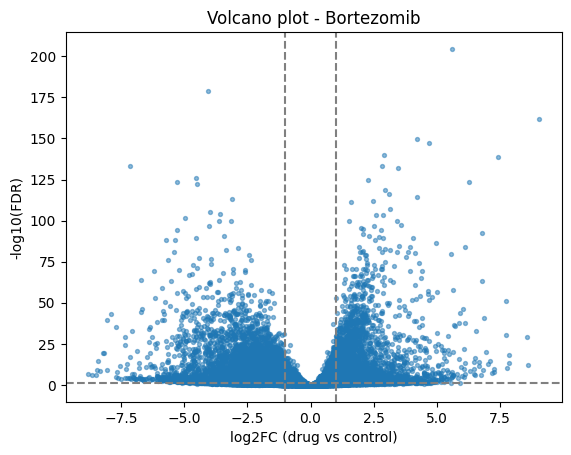

In [11]:
plt.scatter(
    results_df_bor.log2FoldChange, -np.log10(results_df_bor.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (drug vs control)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")
plt.show()

## Gefinitib vs Control

In [12]:
drug = "Gefitinib"

metadata_df_filtered_gef = metadata_df[metadata_df["treatment"].isin([drug, "Control"])]
counts_filtered_gef = counts[metadata_df_filtered_gef.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_gef.T,
    metadata=metadata_df_filtered_gef,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_gef = DeseqStats(deseq_object, contrast=("treatment", "Gefitinib", "Control"))
stat_res_gef.summary()
results_df_gef = stat_res_gef.results_df


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 1.45 seconds.

Fitting dispersion trend curve...
... done in 0.42 seconds.

Fitting MAP dispersions...
... done in 1.46 seconds.

Fitting LFCs...
... done in 1.42 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 184 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: treatment Gefitinib vs Control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
DDX11L1           0.000000             NaN       NaN       NaN       NaN   
WASH7P           67.989688        0.209950  0.243882  0.860867  0.389311   
MIR6859-1         6.570236        0.087165  0.555794  0.156829  0.875380   
MIR1302-2HG       0.205009        0.774081  3.684159  0.210111  0.833581   
MIR1302-2         0.000000             NaN       NaN       NaN       NaN   
...                    ...             ...       ...       ...       ...   
ND6           61270.934214        0.531070  0.514661  1.031884  0.302126   
TRNE              0.576040        0.264362  1.865682  0.141697  0.887319   
CYTB         173670.016579        0.382910  0.426741  0.897290  0.369564   
TRNT              0.066380        0.295672  3.849808  0.076802  0.938781   
TRNP           1076.775011        0.281788  0.349337  0.806637  0.419876   

                 p

... done in 1.29 seconds.



In [13]:
# Get upregulated and downregulated genes
upregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] > 2) & (results_df_gef["padj"] < 0.05)
]
downregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] < -2) & (results_df_gef["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_gef.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_gef.shape[0]}")

    Upregulated genes: 0
    Downregulated genes: 11


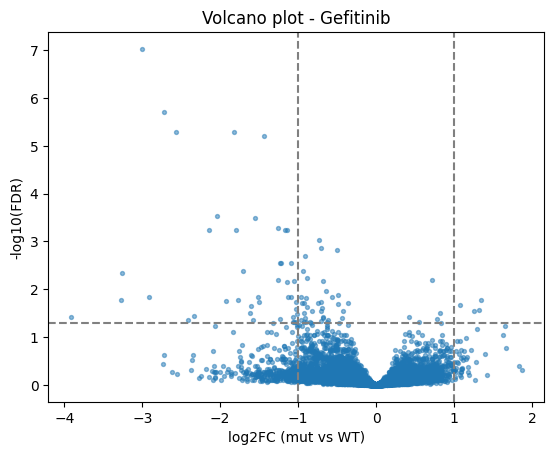

In [14]:
plt.scatter(
    results_df_gef.log2FoldChange, -np.log10(results_df_gef.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (mut vs WT)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")
plt.show()

# GSEAPY

In [15]:
GO_databases = [
    "GO_Biological_Process_2025",
    "GO_Cellular_Component_2025",
    "GO_Molecular_Function_2025",
]

## Bortezomib vs Control

In [16]:
go_upr_results_bor = {}
go_dwr_results_bor = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_bor.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_bor[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_bor.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_bor[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error


    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


### Plot upregulated GO terms

GO_Biological_Process_2025: (2443, 10)
GO_Cellular_Component_2025: (211, 10)
Error occurred while plotting GO_Cellular_Component_2025: Warning: No enrich terms when cutoff = 0.05
GO_Molecular_Function_2025: (491, 10)
Error occurred while plotting GO_Molecular_Function_2025: Warning: No enrich terms when cutoff = 0.05


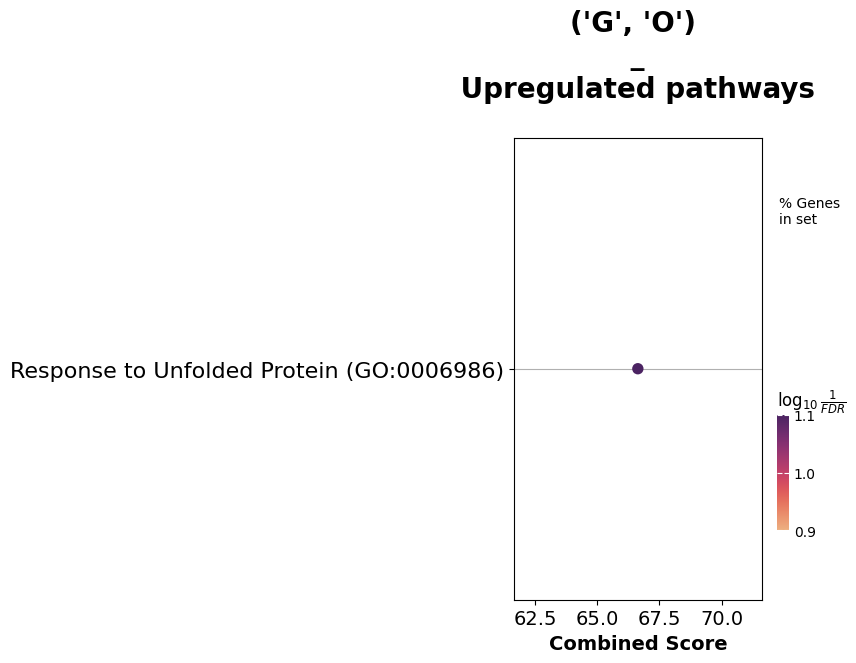

In [17]:
for k, v in go_upr_results_bor.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

In [18]:
display(go_upr_results_bor["GO_Biological_Process_2025"].head(5))

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2025,Response to Unfolded Protein (GO:0006986),12/44,0.000009,0.023092,0,0,5.759016,66.627455,DNAJB1;HSPA8;HSP90AA1;HSP90AB1;HSPH1;HSPB8;DNA...
1,GO_Biological_Process_2025,Cellular Response to Heat (GO:0034605),10/36,0.000044,0.053859,0,0,5.898905,59.161390,DNAJB1;IL1A;HSP90AA1;HSP90AB1;CLPB;BAG3;HSPA6;...
2,GO_Biological_Process_2025,Chaperone Cofactor-Dependent Protein Refolding...,7/25,0.000595,0.484633,0,0,5.952381,44.206747,DNAJB1;HSPA8;DNAJB4;HSPA6;HSPE1;HSPA1B;HSPA1A
3,GO_Biological_Process_2025,Cellular Heat Acclimation (GO:0070370),3/5,0.002122,0.777716,0,0,22.903987,140.979270,HSPA6;HSPA1B;HSPA1A
4,GO_Biological_Process_2025,Heat Acclimation (GO:0010286),3/5,0.002122,0.777716,0,0,22.903987,140.979270,HSPA6;HSPA1B;HSPA1A


### Plot downregulated GO terms

GO_Biological_Process_2025: (3960, 10)
GO_Cellular_Component_2025: (297, 10)
GO_Molecular_Function_2025: (826, 10)
Error occurred while plotting GO_Molecular_Function_2025: Warning: No enrich terms when cutoff = 0.05


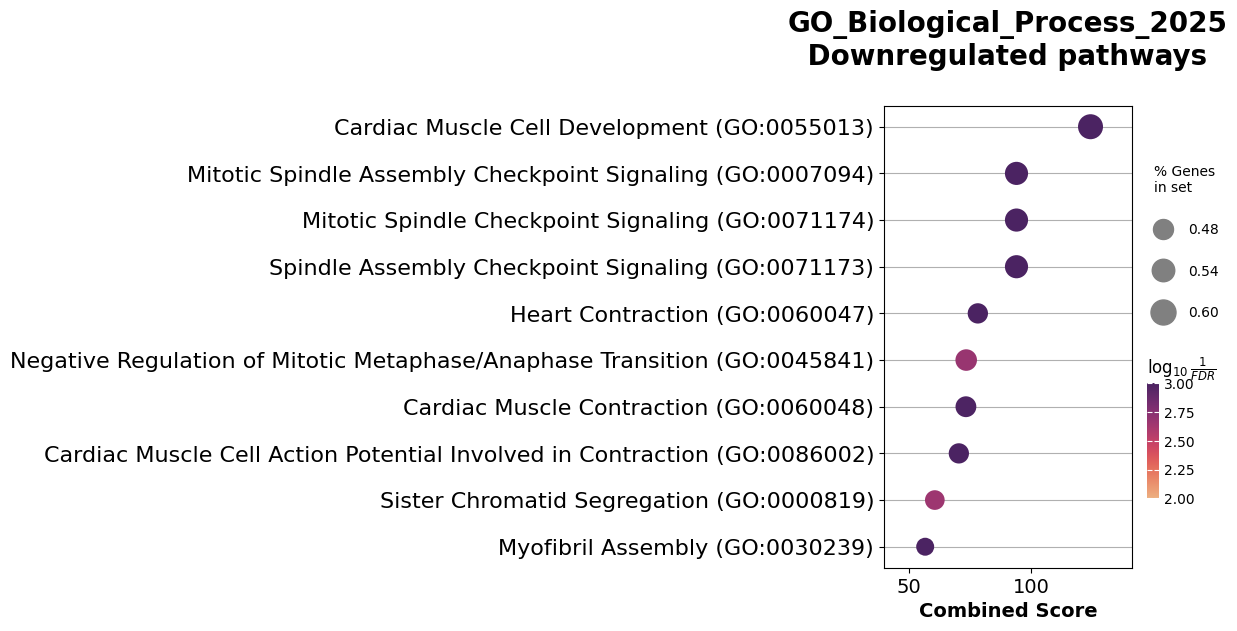

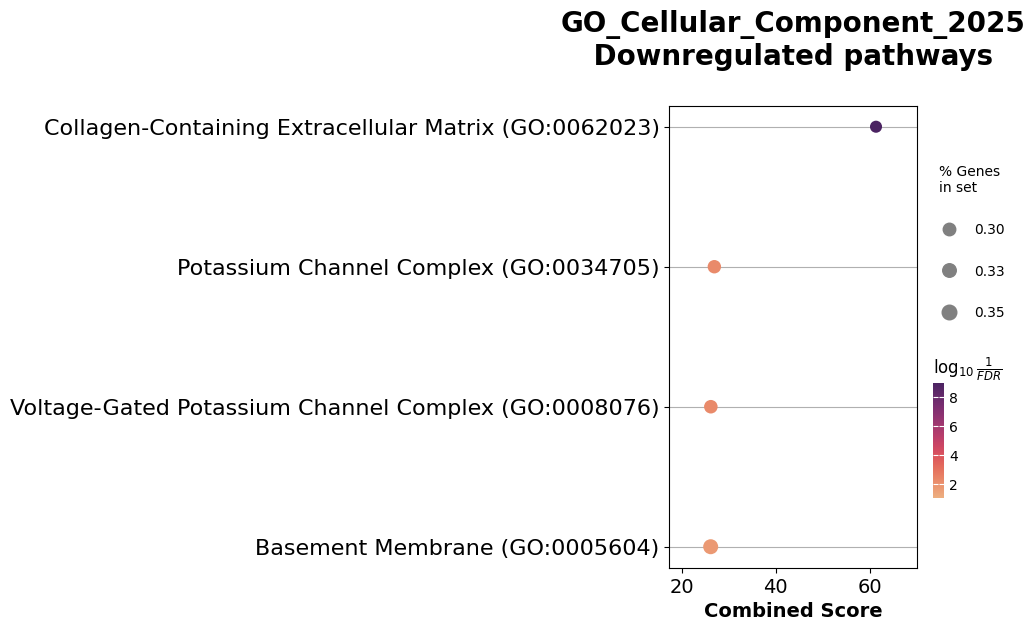

In [19]:
for k, v in go_dwr_results_bor.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k}\n Downregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

In [20]:
# Check out all results for downregulated GO terms (biological process)
go_dwr_results_bor["GO_Biological_Process_2025"][
    go_dwr_results_bor["GO_Biological_Process_2025"]["Adjusted P-value"] < 0.05
]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2025,Cardiac Muscle Cell Development (GO:0055013),15/25,3.735816e-07,0.000862,0,0,8.395145,124.249237,PDGFRB;PDGFRA;BMP10;ADPRHL1;SORBS2;LRRC10;MYLK...
1,GO_Biological_Process_2025,Heart Contraction (GO:0060047),20/41,4.354526e-07,0.000862,0,0,5.335602,78.149917,MYBPC3;KCNE5;TPM1;SLC8A1;MYL4;SGCD;TTR;ACTC1;M...
2,GO_Biological_Process_2025,Mitotic Spindle Assembly Checkpoint Signaling ...,15/27,1.465824e-06,0.000978,0,0,6.995129,93.966218,ZWILCH;PLK1;TTK;HASPIN;NDC80;ZWINT;CDC20;CENPF...
3,GO_Biological_Process_2025,Mitotic Spindle Checkpoint Signaling (GO:0071174),15/27,1.465824e-06,0.000978,0,0,6.995129,93.966218,ZWILCH;PLK1;TTK;HASPIN;NDC80;ZWINT;CDC20;CENPF...
4,GO_Biological_Process_2025,Spindle Assembly Checkpoint Signaling (GO:0071...,15/27,1.465824e-06,0.000978,0,0,6.995129,93.966218,ZWILCH;PLK1;TTK;HASPIN;NDC80;ZWINT;CDC20;CENPF...
5,GO_Biological_Process_2025,Myofibril Assembly (GO:0030239),22/51,1.647938e-06,0.000978,0,0,4.250887,56.604757,MYBPC3;PDGFRB;MYOM1;PDGFRA;BMP10;ADPRHL1;TMOD2...
6,GO_Biological_Process_2025,Cardiac Muscle Cell Action Potential Involved ...,18/37,1.729583e-06,0.000978,0,0,5.304637,70.379959,KCNE1;KCNE3;CAV3;KCNE5;ATP1A4;CACNA1D;KCNA5;CA...
7,GO_Biological_Process_2025,Cardiac Muscle Contraction (GO:0060048),17/34,2.068800e-06,0.001024,0,0,5.598149,73.271612,MYBPC3;KCNE1;KCNE5;TPM1;SLC8A1;MYL4;TTR;KCNQ1;...
8,GO_Biological_Process_2025,Negative Regulation of Mitotic Metaphase/Anaph...,15/29,4.827369e-06,0.002124,0,0,5.995117,73.387480,ZWILCH;PLK1;TTK;HASPIN;NDC80;ZWINT;CDC20;CENPF...
9,GO_Biological_Process_2025,Sister Chromatid Segregation (GO:0000819),17/36,5.615585e-06,0.002224,0,0,5.008279,60.549918,TOP2A;SPAG5;NCAPG2;PLK1;KIF25;KNL1;SKA3;SMC4;S...


## Gefitinib vs Control

In [21]:
go_upr_results_gef = {}
go_dwr_results_gef = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_gef[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_gef[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error


    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


In [22]:
print(go_upr_results_gef)
print(go_dwr_results_gef)

{}
{}


In [23]:
# --> no enriched pathways found

### Plot upregulated GO terms

In [24]:
for k, v in go_upr_results_gef.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

### Plot downregulated GO terms

In [25]:
for k, v in go_dwr_results_gef.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k}\n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")